# Implementing a reparameterized Gamma sampler
Authors: @fritzo, @martinjankowiak

Edited: 2017-11-26 - 2017-12-22

This notebook derives the `standard_gamma_grad(x,alpha)` function that is used to compute reparameterized gradients in `torch.distributions.Gamma().sample()`.

In [1]:
import os
import torch
from torch.autograd import Variable
import numbers
import numpy as np
import scipy.stats
import scipy.optimize
from matplotlib import pyplot
%matplotlib inline

In [2]:
from torch.distributions import Gamma, Normal

In [3]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

First, let's use SciPy to compute the desired reparameterized gradient for given (x, alpha). This is based on the following definition. Let $x\sim \Gamma(\alpha)$ be a standard Gamma random variable. The the reparameterized gradient is 
$$
 \frac {dx}{d\alpha} = -\frac{\frac d{d\alpha}cdf(x;\alpha)}
                             {\frac d{dx}cdf(x;\alpha)}
                     = -\frac{\frac d{d\alpha}cdf(x;\alpha)}{pdf(x;\alpha)}
$$

In [4]:
def dx_dalpha(x, alpha):
    """
    Computes finite-difference approximation of the reparameterized gradient dx/dalpha.
    """
    cdf = scipy.stats.gamma.cdf
    pdf = scipy.stats.gamma.pdf
    if isinstance(alpha, numbers.Number):
        alpha = np.array([alpha])
    eps = 0.01 * alpha / (1.0 + np.sqrt(alpha))
    d_dalpha = (cdf(x, alpha + eps) - cdf(x, alpha - eps)) / (2 * eps)
    d_dx = pdf(x, alpha)
    return -d_dalpha / d_dx

What this computes is the rate of change in x as alpha is varied and a horizontal line is fixed, cutting through cdf() values:

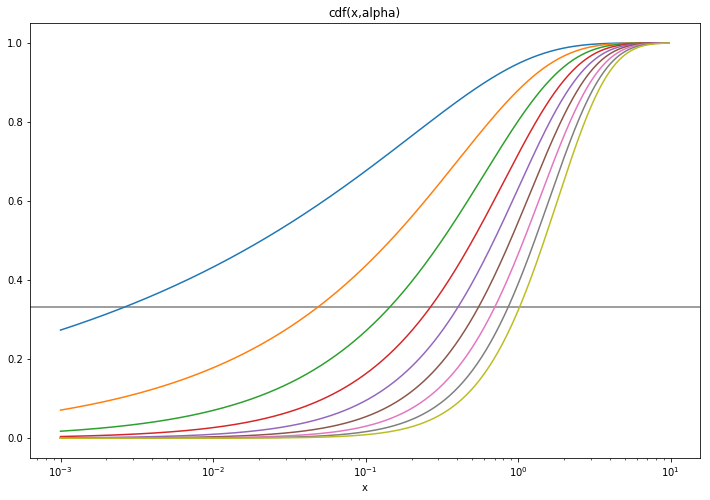

In [5]:
pyplot.figure(figsize=(12,8)).patch.set_facecolor('white')
y = 10 ** np.arange(-3, 1, 0.01)
pyplot.axhline(0.333, color='gray')
for alpha in np.arange(0.2, 2, 0.2):
    pyplot.plot(y, scipy.stats.gamma.cdf(y, alpha))
pyplot.xscale('log')
pyplot.title('cdf(x,alpha)')
pyplot.xlabel('x')
pyplot.show()

Jumping ahead, let's see how our approximation works on randomly drawn samples for various `alpha` values between 0.0001 and 10000 (this uses the torch implementation):

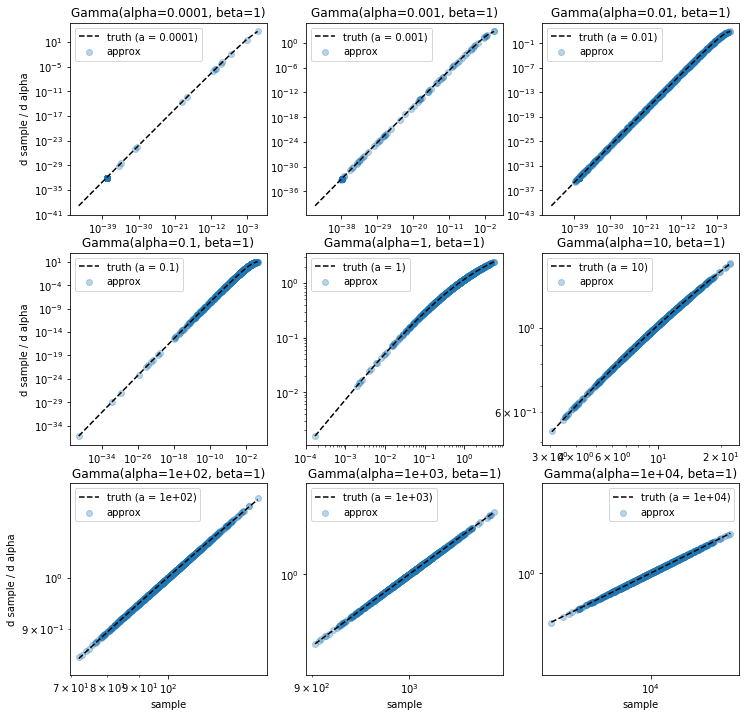

In [6]:
set_seed(0)
alpha = 29
num_samples = 1000
fig, axes = pyplot.subplots(3, 3, figsize=(12,12))
fig.patch.set_facecolor('white')
alpha_grid = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
for i, (ax, alpha) in enumerate(zip(axes.reshape(-1), alpha_grid)):
    alphas = Variable(alpha * torch.ones(num_samples), requires_grad=True)
    betas = Variable(torch.ones(alphas.size()))
    x = Gamma(alphas, betas).rsample()
    x.sum().backward()
    x, ind = x.data.sort()
    x = x.numpy()
    actual_grad = alphas.grad.data[ind].numpy()
    alphas = alphas.data[ind].numpy()
    ax.scatter(x, actual_grad, alpha=0.3, label='approx')
    ax.plot(x, dx_dalpha(x, alpha), 'k--', label='truth (a = {:0.2g})'.format(alpha))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Gamma(alpha={:0.2g}, beta=1)'.format(alpha))
    if i >= 6:
        ax.set_xlabel('sample')
    if i % 3 == 0:
        ax.set_ylabel('d sample / d alpha')
    ax.legend()
pyplot.savefig(os.path.expanduser('~/Downloads/gamma-reparameterized.png'))
pyplot.show()

## Benchmarks

And let's see how expensive the approximation is. It's actually cheaper than the forward sampler.

In [7]:
n = 10
dist = Gamma(Variable(torch.ones(n, 1000, 1000) * 0.9, requires_grad=True),
             Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.rsample()
print('---- Backward ----')
%time x.sum().backward()

---- Forward ----
CPU times: user 938 ms, sys: 23.3 ms, total: 961 ms
Wall time: 961 ms
---- Backward ----
CPU times: user 588 ms, sys: 83.5 ms, total: 672 ms
Wall time: 672 ms


Here's a Normal distribution for comparison.

In [8]:
n = 10
dist = Normal(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
              Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.rsample()
print('---- Backward ----')
%time x.sum().backward()

---- Forward ----
CPU times: user 370 ms, sys: 46 ms, total: 416 ms
Wall time: 416 ms
---- Backward ----
CPU times: user 43.2 ms, sys: 14.9 ms, total: 58.1 ms
Wall time: 57.8 ms


## Approximating the reparameterized gradient

Now let's derive the approximation. Recall the shape of `cdf(x, alpha)` that we want to approximate.

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


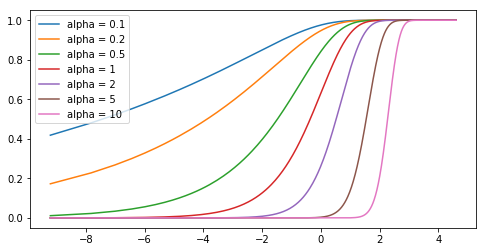

In [9]:
x = np.arange(0, 10, 0.01) ** 2
pyplot.figure(figsize=(8, 4)).patch.set_facecolor('white')
for alpha in [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]:
    pyplot.plot(np.log(x), scipy.stats.gamma.cdf(x, alpha), label='alpha = {:0.2g}'.format(alpha))
pyplot.legend()
pyplot.show()

Following [Knowles (2015)](https://arxiv.org/pdf/1509.01631.pdf), we first approximate `dx_dalpha()` by two asymptotes:
1. For $\alpha << 1$, we differentiate $icdf(z;\alpha) \approx (z\alpha\Gamma(\alpha))^{\frac 1 \alpha}$
2. For $\alpha >> 1$ (e.g. > 1000), we use the Gaussian approximation $\mathcal N(\alpha, \sigma=\alpha)$, whereby the reparameterized gradient is $\nabla_\alpha x = 1 + x\alpha^\frac{-1}2$. An even better approximation is $\nabla_\alpha x = \sqrt{x/\alpha}$; this works well down to $\alpha > 30$.

In [10]:
def dx_dalpha_small_v1(x, alpha):
    return -x / alpha * (np.log(x) - 1.0 / alpha - scipy.special.digamma(alpha))
def dx_dalpha_small_v2(x, alpha):
    gamma_pdf = x**(alpha-1) * np.exp(-x)
    gamma_cdf = x**alpha * (1/alpha - x/(alpha+1) + 0.5*x**2/(alpha+2))
    gamma_cdf_alpha = (np.log(x) - scipy.special.digamma(alpha)) * gamma_cdf \
        - x**alpha * (1/alpha**2 - x/(alpha+1)**2 + 0.5*x**2/(alpha+2)**2)
    return -gamma_cdf_alpha / gamma_pdf
def dx_dalpha_small_v3(x, alpha):
    gamma_pdf = x**(alpha-1) * np.exp(-x)
    gamma_cdf = x**alpha * (1/alpha - x/(alpha+1) + 0.5*x**2/(alpha+2) - (x**3/6.0)/(alpha+3))
    gamma_cdf_alpha = (np.log(x) - scipy.special.digamma(alpha)) * gamma_cdf \
        - x**alpha * (1/alpha**2 - x/(alpha+1)**2 + 0.5*x**2/(alpha+2)**2- (x**3/6.0)/(alpha+3)**2)
    return -gamma_cdf_alpha / gamma_pdf
def dx_dalpha_small_v4(x, alpha):
    gamma_pdf = x**(alpha-1) * np.exp(-x)
    gamma_cdf = x**alpha * (1/alpha - x/(alpha+1) + 0.5*x**2/(alpha+2) - (x**3/6.0)/(alpha+3)\
                           + (x**4/24.0)/(alpha+4))
    gamma_cdf_alpha = (np.log(x) - scipy.special.digamma(alpha)) * gamma_cdf \
        - x**alpha * (1/alpha**2 - x/(alpha+1)**2 + 0.5*x**2/(alpha+2)**2\
                      - (x**3/6.0)/(alpha+3)**2 + (x**4/24.0)/(alpha+4)**2)
    return -gamma_cdf_alpha / gamma_pdf
def dx_dalpha_small_v5(x, alpha):
    gamma_pdf = x**(alpha-1) * np.exp(-x)
    gamma_cdf = x**alpha * (1/alpha - x/(alpha+1) + 0.5*x**2/(alpha+2) - (x**3/6.0)/(alpha+3)\
                           + (x**4/24.0)/(alpha+4) - (x**5/120.0)/(alpha+5))
    gamma_cdf_alpha = (np.log(x) - scipy.special.digamma(alpha)) * gamma_cdf \
        - x**alpha * (1/alpha**2 - x/(alpha+1)**2 + 0.5*x**2/(alpha+2)**2\
                      - (x**3/6.0)/(alpha+3)**2 + (x**4/24.0)/(alpha+4)**2\
                     - (x**5/120.0)/(alpha+5)**2)
    return -gamma_cdf_alpha / gamma_pdf
def dx_dalpha_small_valid(x, alpha):
    return x < 0.8   #  with better expansions this can be as large as .8 or .9ish
dx_dalpha_small = dx_dalpha_small_v5


def dx_dalpha_large(x, alpha):
    # Rice expansion
    far_denominator = np.sqrt(8*alpha)    
    far_term1 = - np.sqrt(2/alpha)*(alpha+x)/(alpha-x)**2
    far_term2 = far_denominator / (alpha-x)
    far_term3 = np.power(x - alpha - alpha*np.log(x/alpha),-1.5)    
    delta = 0.005*alpha
    which = np.piecewise(x, [x < alpha, x > alpha], [-1, 1])
    removable = np.piecewise(x, [np.abs(x - alpha)<delta, np.abs(x - alpha)>=delta], [1, 0])
    far_term23 = far_term2 + which * far_term3
    far_term1 += np.log(x/alpha) * far_term23
    stirling = 1.0 + 1.0/(12.0*alpha) + 1.0/(288.0*alpha**2)    
    far_numerator = x * far_term1 
    far_result = -stirling*far_numerator/far_denominator
    near_num_1 = 1.0 + 24*alpha + 288*alpha**2
    near_num_2 = 1440 * alpha**2 + 6*(53-120*x)*x - 65*x**2/alpha + alpha*(107+3600*x)
    near_denom = 1244160*alpha**4
    near_result = near_num_1*near_num_2/near_denom    
    return (1.0-removable)*far_result + removable*near_result
        
def dx_dalpha_large_valid(x, alpha):
    return alpha > 8.0   # I can imagine this being in the range ~7-10 depending on polynomial approx.

In [11]:
LB, UB = 1e-5, 1e3
alphas = LB * (UB / LB) ** np.random.random(100000)
xs = scipy.stats.gamma.rvs(alphas)
truth = dx_dalpha(xs, alphas)
approximations = [
    ('small1', dx_dalpha_small_v1, dx_dalpha_small_valid),
    ('small2', dx_dalpha_small_v2, dx_dalpha_small_valid),
    ('small3', dx_dalpha_small_v3, dx_dalpha_small_valid),
    ('small4', dx_dalpha_small_v4, dx_dalpha_small_valid),
    ('small5', dx_dalpha_small_v5, dx_dalpha_small_valid),
    ('large', dx_dalpha_large, dx_dalpha_large_valid),
]
print('\t'.join(['version', 'max_err', 'rms_err',
                 'alpha', 'x', 'truth', 'approx', 'volume']))
print('-' * 8 * 8)
for name, approx_fn, is_valid in approximations:
    w = is_valid(xs, alphas) & (truth > 0)
    approx = approx_fn(xs[w], alphas[w])
    error = np.abs(approx - truth[w]) / (1e-10 + truth[w])
    #### sometimes the following is a more useful measure of error
    #error = np.abs(approx - truth[w]) / (np.abs(truth[w]) + np.abs(approx))   
    i = np.argmax(error)
    print('{}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}'.format(
        name, error.max(), (error**2).mean()**0.5,
        alphas[w][i], xs[w][i], truth[w][i], approx[i], w.mean()))

version	max_err	rms_err	alpha	x	truth	approx	volume
----------------------------------------------------------------
small1	1.5	0.17	0.0082	0.79	68	-31	0.38
small2	0.075	0.0044	4.4	0.79	0.39	0.42	0.38
small3	0.013	0.00064	4.4	0.79	0.39	0.38	0.38
small4	0.0018	7.9e-05	4.4	0.79	0.39	0.39	0.38
small5	0.00039	2.1e-05	0.45	1.3e-08	5.3e-07	5.3e-07	0.38
large	0.0007	2.6e-05	8.7	1.9	0.43	0.43	0.26


/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:2329: RuntimeWarning: overflow encountered in exp
  return np.exp(self._logpdf(x, a))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in power
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in power


Let's see how closely these approximations match some example samples:

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in power
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply


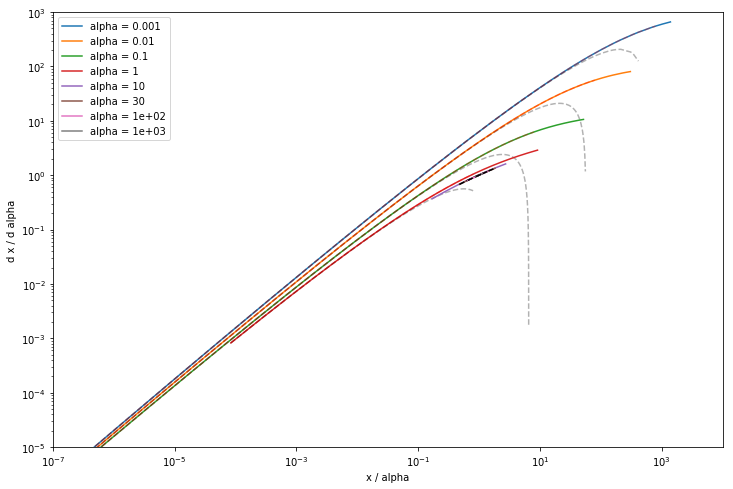

In [12]:
pyplot.figure(figsize=(12, 8)).patch.set_facecolor('white')
for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 30.0, 100.0, 1000.0]:
    x = scipy.stats.gamma.rvs(np.ones(10000) * alpha)
    x.sort()
    u = x / alpha
    pyplot.plot(u, dx_dalpha(x, alpha), label='alpha = {:0.2g}'.format(alpha))
    w = dx_dalpha_small_valid(x, alpha)
    pyplot.plot(u[w], dx_dalpha_small_v1(x[w], alpha), 'k--', alpha=0.3)
    pyplot.plot(u[w], dx_dalpha_small_v5(x[w], alpha), 'r--', alpha=0.3)
    if alpha >= 30:
        pyplot.plot(u, dx_dalpha_large(x, alpha), 'k--')
pyplot.ylabel('d x / d alpha')
pyplot.xlabel('x / alpha')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlim(0.0000001, 10000)
pyplot.ylim(0.00001, 1000)
pyplot.legend()
pyplot.show()

Let's approximate using a bivariate rational function of $\log(x/\alpha)$ and $\log(\alpha)$.

In [13]:
def dx_dalpha_approx(x, alpha, coeff):
    coeff = coeff.reshape((3, 8)).copy()
    coeff[0, 4] = 1
    u = np.log(x / alpha)
    v = np.log(alpha)
    c = [
        cs[0] + u * (cs[1] + u * cs[2])
        for cs in coeff.T
    ]
    p = c[0] + v * (c[1] + v * (c[2] + v * c[3]))
    q = c[4] + v * (c[5] + v * (c[6] + v * c[7]))
    return np.exp(p / np.maximum(q, 1e-2))

In [14]:
np.random.seed(0)
LB, UB = 1e-5, 1e1
alpha_train = np.exp(np.random.random(100000) * (np.log(UB) - np.log(LB)) + np.log(LB))
alpha_train.sort()
x_train = scipy.stats.gamma.rvs(alpha_train)
print('alpha = [{:0.5g}, {:0.5g}, ..., {:0.5g}, {:0.5g}]'.format(
    alpha_train[0], alpha_train[1], alpha_train[-2], alpha_train[-1]))
valid = ~(dx_dalpha_small_valid(x_train, alpha_train) |
          dx_dalpha_large_valid(x_train, alpha_train))
alpha_train = alpha_train[valid]
x_train = x_train[valid]
grad_train = dx_dalpha(x_train, alpha_train)
print(len(grad_train))

alpha = [1e-05, 1.0008e-05, ..., 9.9956, 9.997]
15696


In [15]:
def approx_objective(coeff):
    x = x_train
    alpha = alpha_train
    approx = dx_dalpha_approx(x, alpha, coeff).reshape(-1)
    error = np.empty(len(approx) + 1)
    error[:-1] = 1 - approx / grad_train
    error[-1] = 1 - coeff.reshape((3, 8))[0, 4]
    return error

In [16]:
coeff0 = np.zeros((3, 8))
coeff0[0, 4] = 1
coeff0 = coeff0.reshape(-1)

In [17]:
soln = scipy.optimize.least_squares(approx_objective, coeff0,
                                    xtol=1e-20, ftol=1e-20, gtol=1e-20)
coeff = soln.x
print(soln)
print('coeff = {}'.format(list(coeff)))
error = approx_objective(coeff)
i_worst = np.abs(error).argmax()
print('error = {:0.3g} rms, {:0.3g} max at x={:0.3g}, alpha={:0.3g}'.format(
    (error ** 2).mean() ** 0.5, np.abs(error).max(), x_train[i_worst], alpha_train[i_worst]))

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`ftol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`xtol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:117: UserWarning: `gtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`gtol`", EPS))


 active_mask: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
        cost: 4.083115328530245e-05
         fun: array([  1.10640283e-03,  -1.76870428e-03,  -8.50097786e-04, ...,
         1.02474180e-04,   9.64818310e-05,   0.00000000e+00])
        grad: array([ -6.34851430e-09,   1.64852615e-08,  -3.16947424e-08,
        -2.00340214e-07,   0.00000000e+00,  -2.03445925e-09,
        -7.22306636e-08,   5.18097419e-07,  -1.53202587e-08,
         4.85588700e-08,   1.11406712e-07,  -6.25957116e-07,
         7.35933920e-09,   1.12798832e-07,  -6.28253035e-07,
        -1.46691331e-07,  -5.06817343e-08,  -1.34833174e-07,
         7.86389492e-07,   1.24740063e-07,  -1.08983447e-07,
         6.67309940e-07,   8.34277901e-07,   8.20519830e-08])
         jac: array([[ -6.32915422e-02,   5.60393944e-01,  -4.96182441e+00, ...,
         -4.38872123e+02,   3.88572583e+03,  -3.43952188e+04],
       [ -9.72341448e-02, 

Here's a per-region version that's closer our C implementation:

In [18]:
def dx_dalpha_final(x, alpha):
    result = dx_dalpha_approx(x, alpha, coeff)
    w = dx_dalpha_small_valid(x, alpha)
    result[w] = dx_dalpha_small(x, alpha)[w]
    w = dx_dalpha_large_valid(x, alpha)
    result[w] = dx_dalpha_large(x, alpha)[w]
    return result

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in power
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in power
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encoun

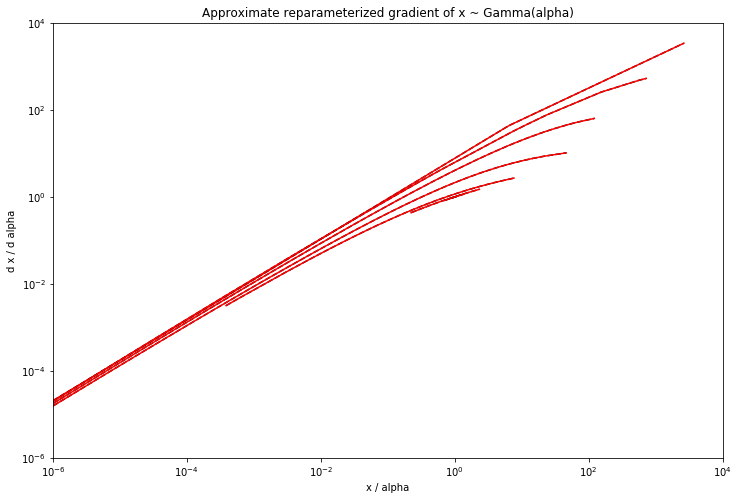

In [19]:
pyplot.figure(figsize=(12, 8)).patch.set_facecolor('white')
for alpha in [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]:
    x = scipy.stats.gamma.rvs(np.ones(1000) * alpha)
    x.sort()
    pyplot.plot(x / alpha, np.maximum(1e-8, dx_dalpha(x, alpha)), 'k--')
    pyplot.plot(x / alpha, np.maximum(1e-8, dx_dalpha_final(x, alpha)), 'r-')
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('x / alpha')
pyplot.ylabel('d x / d alpha')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlim(0.000001, 10000)
pyplot.ylim(0.000001, 10000)
pyplot.legend()
pyplot.show()

## Implementation in C

Let's print out C code for the coefficients and embed this directly in `aten/src/TH/THRandom.c`.

In [20]:
print('static const double coef_uv[3][8] = {')
for row in coeff.reshape(3, 8):
    print('  {' + ', '.join(map('{:0.8g}'.format, row)) +'},')
print('};')

static const double coef_uv[3][8] = {
  {0.16009398, -0.094634809, 0.025146376, -0.0030648343, 1, 0.32668115, 0.10406089, 0.0014179084},
  {0.53487893, 0.1298071, 0.065735949, -0.0015649758, 0.16639465, 0.020070113, -0.0035938915, -0.00058392623},
  {0.040121004, -0.0065914022, -0.0026286047, -0.0013441777, 0.017050642, -0.0021309326, 0.00085092367, -1.5247877e-07},
};


We'll also create an implementation of `dx_dalpha_small()` that's closer to the C implementation. Recall the original implementation
```python
def dx_dalpha_small_v5(x, alpha):
    gamma_pdf = x**(alpha-1) * np.exp(-x)
    gamma_cdf = x**alpha * (1/alpha - x/(alpha+1)
                                    + 0.5*x**2/(alpha+2)
                                    - (x**3/6.0)/(alpha+3)
                                    + (x**4/24.0)/(alpha+4)
                                    - (x**5/120.0)/(alpha+5))
    gamma_cdf_alpha = (np.log(x) - scipy.special.digamma(alpha)) * gamma_cdf \
        - x**alpha * (1/alpha**2 - x/(alpha+1)**2
                                 + 0.5*x**2/(alpha+2)**2
                                 - (x**3/6.0)/(alpha+3)**2
                                 + (x**4/24.0)/(alpha+4)**2
                                 - (x**5/120.0)/(alpha+5)**2)
    return -gamma_cdf_alpha / gamma_pdf
```
Now we'll implement this as a loop in C:

In [21]:
def dx_dalpha_small_c(x, alpha, order=5):
    numer = 1.0
    denom = alpha.copy()
    series1 = numer / denom
    series2 = numer / denom ** 2
    for i in range(1, 1 + order):
        numer *= -x / i
        denom += 1.0
        series1 += numer / denom
        series2 += numer / denom ** 2

    gamma_pdf = x**(alpha-1) * np.exp(-x)
    gamma_cdf = x**alpha * series1
    gamma_cdf_alpha = (np.log(x) - scipy.special.digamma(alpha)) * gamma_cdf \
                    - x**alpha * series2
    return -gamma_cdf_alpha / gamma_pdf

Checking that the two agree:

In [22]:
np.random.seed(0)
LB, UB = 1e-3, 1e2
alpha_train = np.exp(np.random.random(1000) * (np.log(UB) - np.log(LB)) + np.log(LB))
alpha_train.sort()
x_train = scipy.stats.gamma.rvs(alpha_train)
w = (x_train > 1e-10) & dx_dalpha_small_valid(x_train, alpha_train)
x = x_train[w]
alpha = alpha_train[w]
expected = dx_dalpha_small_v5(x, alpha)
actual = dx_dalpha_small_c(x, alpha)
error = actual - expected
i = np.argmax(np.abs(error))
print('error={:0.2g}, alpha={:0.2g}, x={:0.2g}, expected={:0.2g}, actual={:0.2g}'.format(
    error[i], alpha[i], x[i], expected[i], actual[i]))
assert abs(error[i]) < 1e-8, error[i]

error=-6.7e-16, alpha=0.4, x=0.57, expected=1.7, actual=1.7
